In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import numpy as np

In [ ]:
# #https://pythonprogramminglanguage.com/kmeans-text-clustering/
# vectorizer = TfidfVectorizer(stop_words='english')
# #create document to analyze. List of papers with bone/simulation related topics
# documents = ["Application of combined porous tantalum scaffolds loaded with bone morphogenetic protein 7 to repair of osteochondral defect in rabbits. ",
#             "Establishing the relationship between loading parameters and bone adaptation. ",
#             "Importance of a moderate plate-to-bone distance for the functioning of the far cortical locking system. ",
#             "Biological and osseointegration capabilities of hierarchically (meso-/micro-/nano-scale) roughened zirconia. ",
#             "Femoral neck stress in older adults during stair ascent and descent.",
#             "The mathematical simulation and study of the electrical resistance of the friction zone of the hip joint endoprosthesis with a metal-metal friction pair.",
#             "Joint center estimation using single-frame optimization: part 1: numerical simulation.  ",
#             "The peripheral soft tissues should not be ignored in the finite element models of the human knee joint. ",
#              "bone",
#             "Multidic: an open-source toolbox for multi-view 3d digital image correlation."]

# X = vectorizer.fit_transform(documents)
# #number of clusters = 2
# true_k = 2
# model = KMeans(n_clusters=true_k, init='k-means++', max_iter=10, n_init=1) #run model, 10 iterations
# model.fit(X)

# print("Top terms per cluster:")
# order_centroids = model.cluster_centers_.argsort()[:, ::-1] #sorts indexes of most important features
# terms = vectorizer.get_feature_names()
# for i in range(true_k):
#     print("Cluster %d:" % i),
#     for ind in order_centroids[i, :2]:
#         print(' %s' % terms[ind]),
#     print

# #see if the model can predict the category of the word 'bone' and 'simulation' after being trained on [documents]
# print("\n")
# print("Prediction")

# Y = vectorizer.transform(["bone "])
# prediction = model.predict(Y)
# print(prediction) #check i to see which cluster belongs to Bone or Simulation. Bone isn't always 0.


# Y = vectorizer.transform(["simulation"])
# prediction = model.predict(Y)
# print(prediction)

In [ ]:
#http://jonathansoma.com/lede/algorithms-2017/classes/clustering/k-means-clustering-with-scikit-learn/
# import pandas as pd
# from textblob import TextBlob
# from mpl_toolkits.mplot3d import Axes3D
# def textblob_tokenizer(str_input):
#     blob = TextBlob(str_input.lower())
#     tokens = blob.words
#     words = [token.stem() for token in tokens]
#     return words

# vec = TfidfVectorizer(tokenizer=textblob_tokenizer,
#                     stop_words = 'english', #get rid of stop words
#                     use_idf = True,
#                     max_features=3)
# matrix = vec.fit_transform(documents)
# df = pd.DataFrame(matrix.toarray(), columns = vec.get_feature_names())
# print(df.head(2))

# #cluster
# km = KMeans(n_clusters = 4)
# km.fit(df)

# #assign the category to df
# df['category'] = km.labels_

# #build cmap
# colormap = {0: 'red', 1: 'green', 2: 'blue', 3: 'orange'} #extra color
# colors = df.apply(lambda row: colormap[row.category],axis = 1)


# def draw(ax, df):
#     colormap = { 0: 'red', 1: 'green', 2: 'blue', 3: 'orange' } #extra color
#     colors = df.apply(lambda row: colormap[row.category], axis=1)

#     ax.scatter(df[vec.get_feature_names()[0]],
#                df[vec.get_feature_names()[1]],
#                df[vec.get_feature_names()[2]], c=colors, s=100, alpha=0.5)
#     ax.set_xlabel(vec.get_feature_names()[0])
#     ax.set_ylabel(vec.get_feature_names()[1])
#     ax.set_zlabel(vec.get_feature_names()[2])

# chart_count_vert = 5
# chart_count_horiz = 5
# number_of_graphs = chart_count_vert * chart_count_horiz

# fig = plt.figure(figsize=(3 * chart_count_horiz, 3 * chart_count_vert))

# for i in range(number_of_graphs):
#     ax = fig.add_subplot(chart_count_horiz, chart_count_vert, i + 1, projection='3d', azim=(-360 / number_of_graphs) * i)
#     draw(ax, df)

In [ ]:
# #training list of titles and keywords (bone* AND muscle* )
# list1 = ["Bone fracture healing",
#          "Chondrogenic growth factors",
#          "Dynamic loading",
#          "Mesenchymal stem cells",
#          "Osteogenic growth factors",
#          "Biomechanics",
#         " Cruciate",
#         "Knee",
#         "Laxity",
#         "Measurement",
#         "Rotatometer",
#         "graft-to-bone healing",
#         "ligament reconstruction",
#         "rabbit model",
#         "Trabecular microstructure",
#         ]
# #test list
# list2 = ["Anterior Cruciate Ligament"]
         
# vectorizer = TfidfVectorizer(stop_words = 'english',                    
#                              use_idf = True,
#                             max_features =2)

# vec = vectorizer.fit(list1) #train vec using list1
# vectorized = vec.transform(list1) #transform list1 using vec
# km = KMeans(n_clusters = 2,
#            init = 'k-means++',
#            n_init = 1,
#            max_iter= 100,
#            precompute_distances = True,
#            random_state = None,
#            n_jobs =1)
# matrix = vec.fit_transform(list1)
# df = pd.DataFrame(matrix.toarray(), columns = vec.get_feature_names())
# print(df)

# km.fit(vectorized)
# #test km model on new list of words (list2)
# list2Vec = vec.transform(list2) #transform list2 using vec
# print('\nprediction for list2:')
# list2pred = km.predict(list2Vec)[0]
# print(vec.get_feature_names()[list2pred])


In [ ]:
# #https://towardsdatascience.com/a-production-ready-multi-class-text-classifier-96490408757
# #A Production ready Multi-Class Text Classifier
# import pandas as pd
# import numpy as np
# #load data
# df = pd.read_csv("/Users/ryanalcantara/Professional Drive/Subreddit/code_repo/literature_update/RYANDATA_consolidated.csv")
# #doesn't like pick of the week because there's only 1 of its category. Need to consolidate PoW papers.


# from collections import Counter
# print(Counter(df["topic"]))

# #preprocessing
# import re
# def clean_str(string):
#     """
#     Tokenization/string cleaning for dataset
#     Every dataset is lower cased except
#     """
#     string = re.sub(r"\n", "", string)    
#     string = re.sub(r"\r", "", string) 
#     string = re.sub(r"[0-9]", "digit", string)
#     string = re.sub(r"\'", "", string)    
#     string = re.sub(r"\"", "", string)    
#     return string.strip().lower()
# X = []
# for i in range(df.shape[0]):
#     X.append(clean_str(df.iloc[i][1]))
# y = np.array(df["topic"])


In [ ]:
# #https://towardsdatascience.com/a-production-ready-multi-class-text-classifier-96490408757
# #A Production ready Multi-Class Text Classifier
# import pandas as pd
# import numpy as np
# #load data
# df = pd.read_csv("/Users/ryanalcantara/Professional Drive/Subreddit/code_repo/literature_update/RYANDATA_consolidated.csv")
# #doesn't like pick of the week because there's only 1 of its category. Need to consolidate PoW papers.


# from collections import Counter
# print(Counter(df["topic"]))

# #preprocessing
# import re
# def clean_str(string):
#     """
#     Tokenization/string cleaning for dataset
#     Every dataset is lower cased except
#     """
#     string = re.sub(r"\n", "", string)    
#     string = re.sub(r"\r", "", string) 
#     string = re.sub(r"[0-9]", "digit", string)
#     string = re.sub(r"\'", "", string)    
#     string = re.sub(r"\"", "", string)    
#     return string.strip().lower()
# X = []
# for i in range(df.shape[0]):
#     X.append(clean_str(df.iloc[i][1]))
# y = np.array(df["topic"])

# #train on 70% of data, test on 30%
# #train test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=5)

# #pipeline
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.svm import LinearSVC

# model = Pipeline([("vectorizer", CountVectorizer()),
#  ("tfidf", TfidfTransformer()),
#  ("clf", OneVsRestClassifier(LinearSVC(class_weight= "balanced")))])
# #the class_weight="balanced" option tries to remove the biasedness of model towards majority sample

# #paramater selection
# from sklearn.grid_search import GridSearchCV
# parameters = {'vectorizer__ngram_range': [(1, 1), (1, 2),(2,2)],
#                'tfidf__use_idf': (True, False)}
# gs_clf_svm = GridSearchCV(model, parameters, n_jobs=-1)
# gs_clf_svm = gs_clf_svm.fit(X, y)
# print(gs_clf_svm.best_score_)
# print(gs_clf_svm.best_params_)

# #preparing the final pipeline using the selected parameters
# model = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,2))),
#     ('tfidf', TfidfTransformer(use_idf=True)),
#     ('clf', OneVsRestClassifier(LinearSVC(class_weight="balanced")))])

# #fit model with training data
# model.fit(X_train, y_train)
# #evaluation on test data
# pred = model.predict(X_test)
# from sklearn.metrics import confusion_matrix, accuracy_score
# confusion_matrix(pred, y_test)

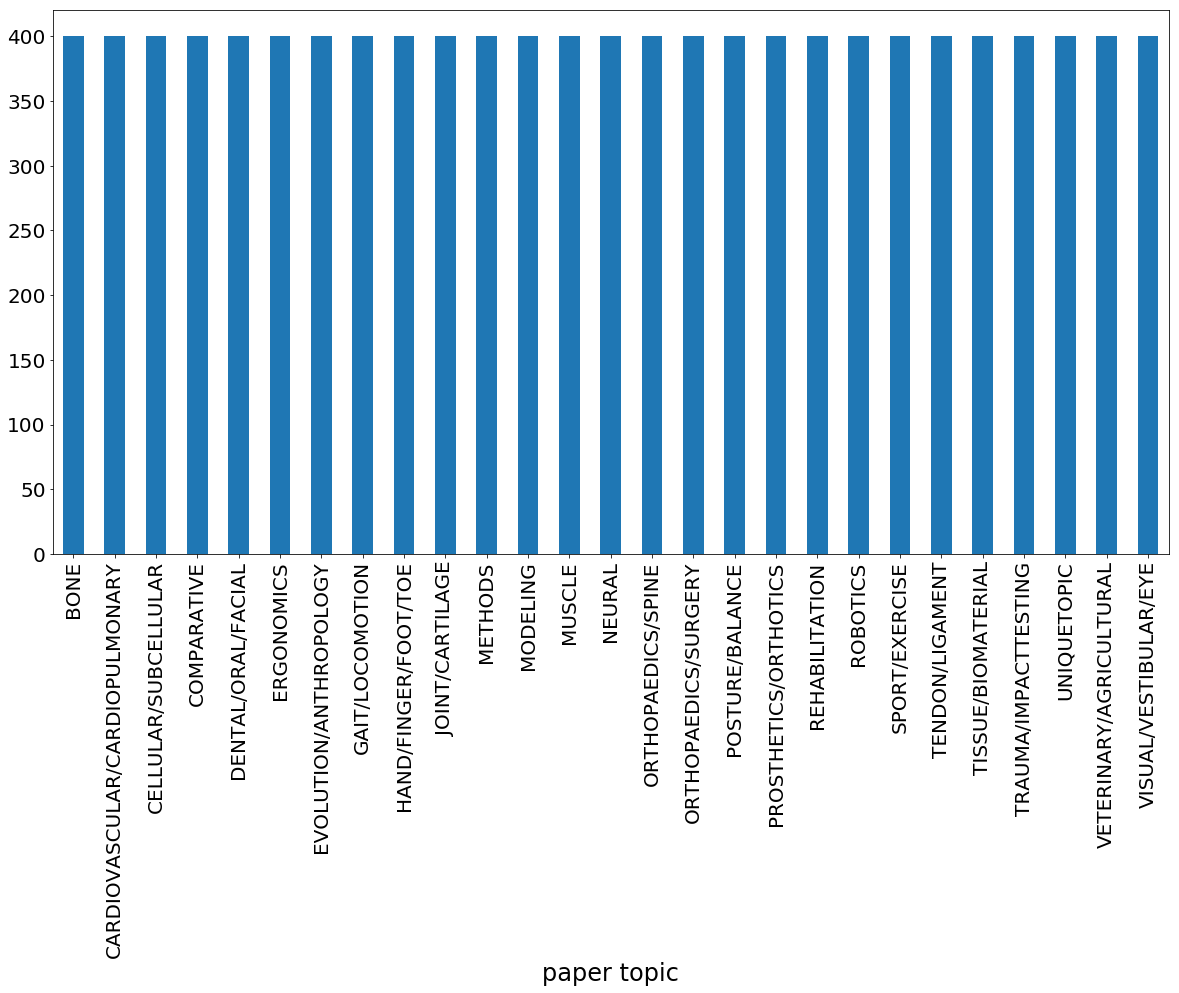

In [2]:
#https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
%matplotlib inline
import pandas as pd
from io import StringIO
#mac
#df = pd.read_csv("/Users/ryanalcantara/Google Drive/Subreddit/biomch_l_list.csv")
#pc
df = pd.read_csv("/Users/ryanalcantara/Professional Drive/Subreddit/code_repo/literature_update/RYANDATA_trim.csv")

col = ['topic','title']
df = df[col]
df = df[pd.notnull(df['title'])]

df.columns = ['topic','title']

df['topic_id'] = df['topic'].factorize()[0]
topic_id_df = df[['topic',
                  'topic_id']].drop_duplicates().sort_values('topic_id')
topic_to_id = dict(topic_id_df.values)
id_to_topic = dict(topic_id_df[['topic_id','topic']].values)
df.sample(5)

#histo of topics (ideally have >600 each)
import matplotlib.pyplot as plt
plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)
fig = plt.figure(figsize= (20,10))
df.groupby('topic').title.count().plot.bar(ylim=0)
plt.xlabel("paper topic",fontsize = 24)
plt.show()

#need to consolidate Pick of the Week papers (or just exclude them)

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf = True,
                       min_df = 1,
                       norm = 'l2',
                       encoding = 'latin-1',
                       ngram_range = (1,2),
                       stop_words = 'english')

features = tfidf.fit_transform(df.title).toarray()
labels = df.topic_id
print(features.shape) #(a,b) a num of titles is represented by b num of features

from sklearn.feature_selection import chi2
import numpy as np

N = 2
for topic, topic_id in sorted(topic_to_id.items()):
    features_chi2 = chi2(features, labels == topic_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    #print("# '{}':".format(topic))
    #print(". Most correlated unigrams:\n . {}".format('\n . '.join(unigrams[-N:])))
    #print(". Most correlated bigrams:\n . {}".format('\n . '.join(bigrams[-N:])))
    #print("")

In [ ]:
#naive bayes classifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['title'],
                                                    df['topic'],
                                                    random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf,y_train)

print(clf.predict(count_vect.transform([
    "The simple chaotic model of passive dynamic walking. ",
]))) #
#needs some help still...

#df[df['title'] == "Journey into bone models: a review."]
#not broken!



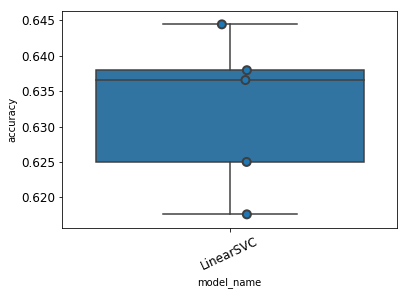

model_name
LinearSVC    0.632315
Name: accuracy, dtype: float64

In [3]:
#model selection!

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf = True,
                       min_df = 1,
                       norm = 'l2',
                       encoding = 'latin-1',
                       ngram_range = (1,2),
                       stop_words = 'english')
# https://scikit-learn.org/stable/modules/multiclass.html
features = tfidf.fit_transform(df.title).toarray()
labels = df.topic_id

models = [
    #RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0), #sucks
    LinearSVC(multi_class='ovr', random_state=0), #one vs rest (all)
#     SGDClassifier(max_iter=500, random_state=0, tol = 1e-3),
#     PassiveAggressiveClassifier(max_iter = 500, random_state = 0, tol = 1e-3)
    #MultinomialNB(),
    #LogisticRegression(random_state=0, solver = 'liblinear', multi_class = 'ovr'),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
plt.rc('xtick',labelsize = 12)
plt.rc('ytick',labelsize = 12)
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.xticks( rotation='25')

plt.show()

cv_df.groupby('model_name').accuracy.mean()

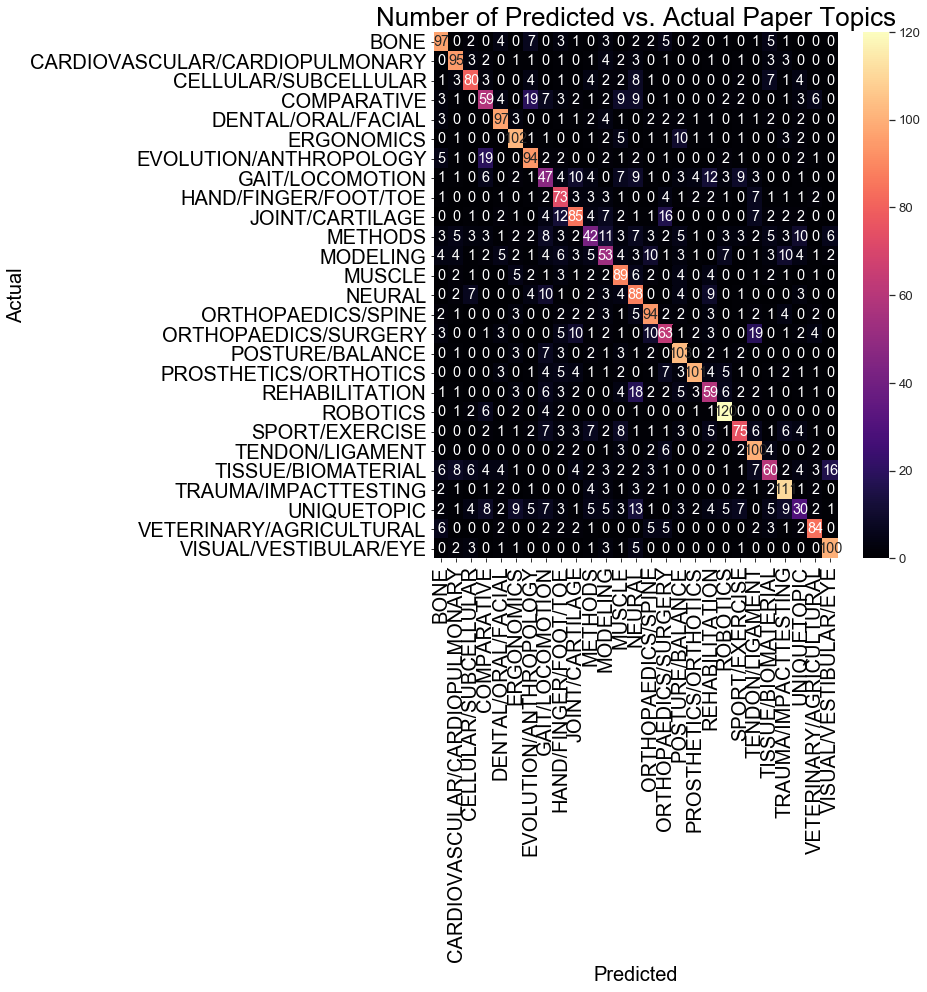

In [5]:
from sklearn.model_selection import train_test_split
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
fig.tight_layout(pad = 8)
sns.set(font_scale=1.2) #font size multiplier
sns.heatmap(conf_mat, annot=True, fmt='d', cmap = 'magma',
            xticklabels=topic_id_df.topic.values, yticklabels=topic_id_df.topic.values)

plt.ylabel('Actual',fontsize = 20)
plt.xlabel('Predicted',fontsize = 20)
plt.title('Number of Predicted vs. Actual Paper Topics', fontsize = 26)
plt.yticks( rotation='horizontal')

plt.savefig('biomchL_predict_plot.png')
plt.show()


In [6]:
from IPython.display import display

# for predicted in topic_id_df.topic_id:
#     for actual in topic_id_df.topic_id:
#         if predicted != actual and conf_mat[actual, predicted] >= 2:
#             print("'{}' predicted as '{}' : {} examples.".format(id_to_topic[actual], id_to_topic[predicted], conf_mat[actual, predicted]))
#             display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['topic', 'title']])
#             print('')
            

from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['topic'].unique()))

                                precision    recall  f1-score   support

                          BONE       0.69      0.71      0.70       136
CARDIOVASCULAR/CARDIOPULMONARY       0.73      0.78      0.75       122
          CELLULAR/SUBCELLULAR       0.71      0.65      0.68       123
                   COMPARATIVE       0.51      0.44      0.47       134
            DENTAL/ORAL/FACIAL       0.73      0.77      0.75       126
                    ERGONOMICS       0.72      0.77      0.74       133
        EVOLUTION/ANTHROPOLOGY       0.64      0.70      0.67       135
               GAIT/LOCOMOTION       0.38      0.37      0.37       128
          HAND/FINGER/FOOT/TOE       0.51      0.66      0.58       110
               JOINT/CARTILAGE       0.62      0.57      0.59       149
                       METHODS       0.43      0.30      0.36       138
                      MODELING       0.43      0.38      0.40       140
                        MUSCLE       0.56      0.69      0.62  

In [ ]:
# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold

model = LinearSVC()
features = tfidf.fit_transform(df.title).toarray()
df['topic_id'] = df['topic'].factorize()[0]
labels = df.topic_id
# data sample
#print(df.sample(10))
# prepare cross validation
kfold = KFold(10, True)
# enumerate splits
for train, test in kfold.split(df):
    train, test =  df.iloc[train], df.iloc[test]
    X_train = tfidf.fit_transform(train.title).toarray()
    X_test = tfidf.fit_transform(test.title).toarray()
    y_train = train.topic_id
    y_test = test.topic_id
#     X_train, y_train = train['title'], train['topic']
#     X_test, y_test = test['title'], test['topic']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(accuracy_score(y_test, y_pred))
    
   
    
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
# print(labels)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# from sklearn.metrics import confusion_matrix
# plt.rc('xtick',labelsize = 20)
# plt.rc('ytick',labelsize = 20)
# conf_mat = confusion_matrix(y_test, y_pred)
# fig, ax = plt.subplots(figsize=(10,10))
# fig.tight_layout(pad = 8)
# sns.set(font_scale=1.2) #font size multiplier
# sns.heatmap(conf_mat, annot=True, fmt='d', cmap = 'magma',
#             xticklabels=topic_id_df.topic.values, yticklabels=topic_id_df.topic.values)

# plt.ylabel('Actual',fontsize = 20)
# plt.xlabel('Predicted',fontsize = 20)
# plt.title('Number of Predicted vs. Actual Paper Topics', fontsize = 26)
# plt.yticks( rotation='horizontal')

# plt.savefig('biomchL_predict_plot.png')
# plt.show()
